<a href="https://colab.research.google.com/github/ego-alt/segmentation-from-scratch/blob/master/instance_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -o -j -q -d ./full_images /content/drive/MyDrive/MP6843_img_full.zip
!unzip -o -j -q -d ./labels /content/drive/MyDrive/MP6843_inst.zip

In [5]:
import numpy as np
from os import listdir
from os.path import join
import cv2
import re

In [6]:
class ArrayMaker:
    """Handles image datasets by resizing, cropping and converting to arrays"""
    def __init__(self, root_path):
        self.root = root_path
        self.files = {}  # Directory for image versions/ layers
        self.arrdict = {}  # Holds image arrays

        self.org_files()

    def main(self, dim=None, crop=None, greyscale=False):
        for name in self.files:
            for i in self.files[name]:
                if greyscale: im = cv2.imread(join(self.root, i), 0)
                else: im = cv2.imread(join(self.root, i))
                if dim: im = cv2.resize(im, dim, interpolation=cv2.INTER_AREA)

                im = np.array(im)
                if crop:  # Center crop
                    y, x, *_ = im.shape
                    x0 = (x - crop) // 2
                    y0 = (y - crop) // 2
                    im = im[x0:x0 + crop, y0:y0 + crop]
                self.listdict(self.arrdict, name, im)

    def org_files(self):
        """Image variants can be accessed under the same key in a dictionary"""
        regex = "^F0[1-4]_[0-9]+"  # Filename shared between versions/ layers
        for file in sorted(listdir(self.root)):
            if not file.startswith('.'):
                filename = re.findall(regex, file)[0]
                self.listdict(self.files, filename, file)

    def common_elements(self, other):
        """Ensures images and labels can be paired up properly"""
        stored = {k:self.arrdict[k] for k in self.arrdict if k in other}
        self.arrdict = stored

    def filtering(self, keyword):
        """Filters images given specific criteria in their filenames"""
        filtered = []
        for name in self.files:
            filename = self.files[name]
            f = [filename.index(i) for i in filename if keyword in i]
            filtered.extend(self.arrdict[name][i] for i in f)
        return filtered  # List of filtered image arrays

    def stacking(self):
        """Stacks different layers of an image into a single array"""
        stacked = [np.stack(self.arrdict[name],axis=-1) for name in self.arrdict]
        return stacked  # List of 3D segmentation arrays

    def listdict(self, dictionary, key, value):
        """Updates a dictionary of lists"""
        if key not in dictionary:
            dictionary[key] = list()
        dictionary[key].append(value)

In [7]:
lb_root = './labels'
im_root = './full_images'
dim = (696, 520)

labels = ArrayMaker(lb_root)
images = ArrayMaker(im_root)

labels.main(crop=256, greyscale=True)
images.main(dim=dim, crop=256)
images.common_elements(labels.arrdict)  # Only keeps images with labels

w1 = images.filtering('w1')  # Images of full cells
w2 = images.filtering('w2')  # Images of nuclei only
labels3d = labels.stacking()  # 3D segmentations
alternating = [w1[i] if i % 2 == 0 else w2[i] for i in range(len(w1))]

In [8]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../

In [10]:
class CellImages(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, ind):
        img = self.transform(self.images[ind])
        lbl = self.labels[ind]
        _, _, stack_num = lbl.shape  # Number of layers

        masks = None
        for i in range(stack_num):
            # Iterates over layers in a 3D segmentation
            layer = lbl[:, :, i]  
            obj_ids = np.unique(layer)[1:]  # Excludes the background
            # Set of binary masks for each cell
            if masks is None:
                masks = layer == obj_ids[:, None, None]
            else:
                current = layer == obj_ids[:, None, None]
                masks = np.concatenate((masks, current), axis=0)
        mask_num, _, _ = masks.shape  # Number of unique cells

        boxes = []
        # Locates bounding boxes for each cell
        for i in range(mask_num):
            coord = np.where(masks[i])  # Coordinates for "is cell"
            x0, x1 = np.min(coord[1]), np.max(coord[1])
            y0, y1 = np.min(coord[0]), np.max(coord[0])
            if x0 < x1 and y0 < y1:
              boxes.append([x0, y0, x1, y1])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)  # Box coordinates
        labels = torch.ones((mask_num,), dtype=torch.int64)  # Only 1 class
        masks = torch.as_tensor(masks, dtype=torch.uint8)  # Segmentation masks
        image_id = torch.as_tensor([ind])  # Unique image identifier
        area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        iscrowd = torch.zeros((mask_num,), dtype=torch.int64)

        # Required for the pretrained Mask R-CNN
        target = {}
        target["boxes"] = boxes 
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area  
        target["iscrowd"] = iscrowd

        return img, target

In [11]:
train = CellImages(w1[0:70], labels3d[0:70])
train_loader = DataLoader(train, 
                          batch_size=5, shuffle=False, 
                          collate_fn=lambda x:list(zip(*x)))

test_loader = DataLoader(CellImages(w1[70:90], labels3d[70:90]), 
                          batch_size=5, shuffle=False,
                          collate_fn=lambda x:list(zip(*x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


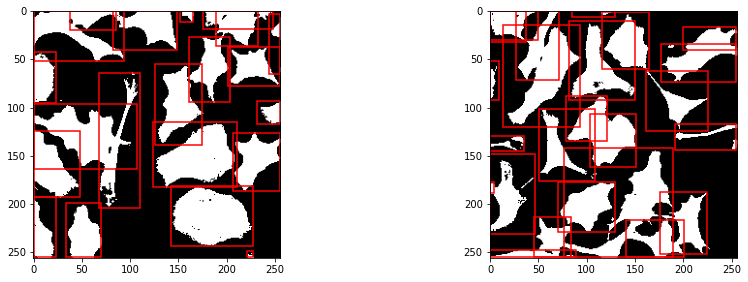

In [12]:
import matplotlib.pyplot as plt
from matplotlib import patches

images, labels = next(iter(train_loader))  # Batch of 5

def view(images, labels, n=2, std=1, mean=0):
    figure = plt.figure(figsize=(15,10))
    images = list(images)
    labels = list(labels)
    for i in range(n):
        out = torchvision.utils.make_grid(images[i])  
        ax = figure.add_subplot(2, 2, i + 1)
        ax.imshow(images[i].cpu().numpy().transpose((1,2,0)) * 255)
        l = labels[i]['boxes'].cpu().numpy()
        l[:,2] = l[:,2] - l[:,0]
        l[:,3] = l[:,3] - l[:,1]
        for j in range(len(l)):
            ax.add_patch(patches.Rectangle((l[j][0],l[j][1]),l[j][2],l[j][3],
                                           linewidth=1.5,
                                           edgecolor='r',
                                           facecolor='none')) 

view(images=images, labels=labels, n=2, std=1, mean=0)

In [13]:
def instance_segmentation(num_classes):
    """Load an instance segmentation model pretrained on COCO"""
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    # Number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pretrained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    hidden_layer = 256
    # Number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    # Replace the pretrained mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

epochs = 50
num_classes = 2  # "is cell" or "not cell"
model = instance_segmentation(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                   max_lr=0.05,
                                                   steps_per_epoch=len(train), 
                                                   epochs=epochs)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [15]:
from engine import train_one_epoch, evaluate

for epoch in range(epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, test_loader, device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [ 0/14]  eta: 0:00:22  lr: 0.000156  loss: 7.8082 (7.8082)  loss_classifier: 0.6436 (0.6436)  loss_box_reg: 0.8985 (0.8985)  loss_mask: 1.3395 (1.3395)  loss_objectness: 4.6118 (4.6118)  loss_rpn_box_reg: 0.3148 (0.3148)  time: 1.5949  data: 0.0407  max mem: 4770
Epoch: [0]  [10/14]  eta: 0:00:04  lr: 0.001693  loss: 3.2002 (4.5191)  loss_classifier: 0.5754 (0.5321)  loss_box_reg: 0.8781 (0.7546)  loss_mask: 0.9015 (0.9867)  loss_objectness: 0.6568 (1.9525)  loss_rpn_box_reg: 0.3148 (0.2932)  time: 1.2442  data: 0.0375  max mem: 5277
Epoch: [0]  [13/14]  eta: 0:00:01  lr: 0.002000  loss: 2.6780 (3.8782)  loss_classifier: 0.4759 (0.4828)  loss_box_reg: 0.6579 (0.6604)  loss_mask: 0.8740 (0.9284)  loss_objectness: 0.3641 (1.5681)  loss_rpn_box_reg: 0.2594 (0.2385)  time: 1.1965  data: 0.0329  max mem: 5277
Epoch: [0] Total time: 0:00:16 (1.1970 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:04  model_time: 0.7548 (0.7548)  evaluator_time: 0.3065 (0.3065)  ti

In [46]:
from PIL import Image

class ImageTest:
    def __init__(self, test_img):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        self.img = test_img
        self.classes = ['__background__', 'cell']

    def main(self, model, conf=0.5):
        figure = plt.figure(figsize=(15,10))

        for ind, i in enumerate(self.img):
            i = self.transform(i).to(device)
            boxes, classes, masks = self.run_model(model, i, conf)
            ax = figure.add_subplot(2, 2, ind + 1)
            image = self.from_gpu(i).transpose(1,2,0)
            image = Image.fromarray(np.uint8(image * 255)).convert('L')
            ax.imshow(image, cmap='gray')
            self.show_boxes(boxes, ax)
            self.show_masks(masks, ax)

    def show_boxes(self, boxes, ax):
        for j in range(len(boxes)):
            x, y = boxes[j][0]
            x1, y1 = boxes[j][1]
            width, height = x1 - x, y1 - y
            ax.add_patch(patches.Rectangle(
                (x, y), width, height,
                linewidth=1.5, edgecolor='r', facecolor='none'
            ))

    def show_masks(self, masks, ax):
        masks = np.multiply(masks, 1)
        for j in range(len(masks)):
            masks[j] = masks[j] * (j + 1)
        masks = sum(masks)
        masks = Image.fromarray(np.uint8(masks))
        ax.imshow(masks, cmap='jet', alpha=0.5)

    def run_model(self, model, img, conf):
        model.eval()
        pred = model([img])
        pred_score = list(pred[0]['scores'].detach().cpu().numpy())
        pred_conf = [pred_score.index(x) for x in pred_score if x > conf][-1]

        boxes = self.from_gpu(pred[0]['boxes'])
        boxes = [[(i[0], i[1]), (i[2], i[3])] for i in boxes]
        labels = [self.classes[i] for i in self.from_gpu(pred[0]['labels'])]
        masks = self.from_gpu((pred[0]['masks'] > 0.5).squeeze())

        pred_boxes = boxes[:pred_conf + 1]
        pred_class = labels[:pred_conf + 1]
        pred_masks = masks[:pred_conf + 1]

        return pred_boxes, pred_class, pred_masks

    def from_gpu(self, tensor):
        return tensor.detach().cpu().numpy()

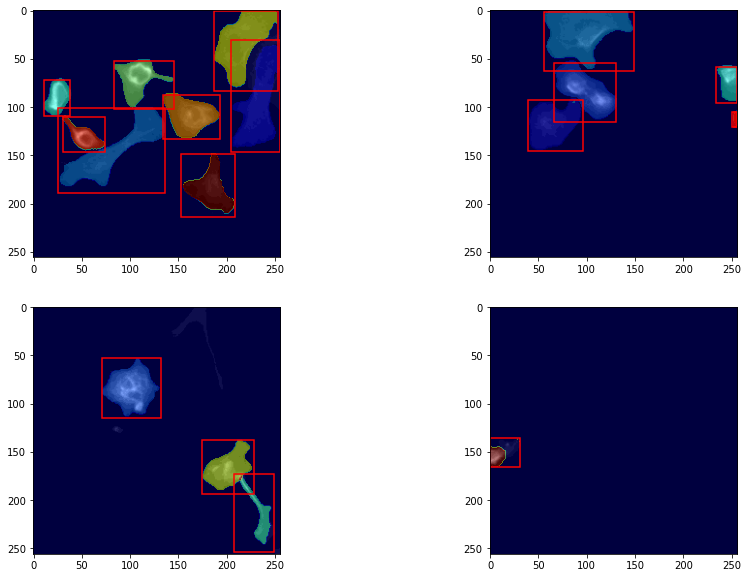

In [47]:
testone = ImageTest(w1[96:100])
testone.main(model, 0.90)